In [1]:
import graph_tool.all as gt
from math import sqrt

In [2]:
from random import *

In [3]:
from libs.community_detection.o import *

In [4]:
csvGraphsPath="../graphs/csv/"
csvGraphFileName="facebook_combined.csv"
csvGraphFilePath=csvGraphsPath+csvGraphFileName
formatedGraphPath="../graphs/formatted/"
fbGraph=gt.load_graph_from_csv(csvGraphFilePath)

In [5]:
import igraph as ig

In [6]:
F=ig.Graph.Read("../graphs/formatted/facebook_combined.txt",format="ncol").as_undirected()

In [7]:
nbWorkers=100

In [8]:
%time workerIds,partition,clusterGraph,clusterIds=assignWorkers(F,nbWorkers)
print(workerIds)

igraph.Vertex(<igraph.Graph object at 0x7f1720a96a90>, 349, {'name': 'V2740', 'color': (1, 0.0, 0.0), 'cluster': 0})
CPU times: user 33.6 ms, sys: 0 ns, total: 33.6 ms
Wall time: 33.3 ms
igraph.Vertex(<igraph.Graph object at 0x7f1720a96a90>, 430, {'name': 'V1967', 'color': (1, 0.0, 0.4615384615384617), 'cluster': 1})
CPU times: user 52.9 ms, sys: 0 ns, total: 52.9 ms
Wall time: 51.9 ms
igraph.Vertex(<igraph.Graph object at 0x7f1720a96a90>, 434, {'name': 'V1911', 'color': (1, 0.46153846153846156, 0.0), 'cluster': 2})
CPU times: user 67.4 ms, sys: 0 ns, total: 67.4 ms
Wall time: 67.3 ms
igraph.Vertex(<igraph.Graph object at 0x7f1720a96a90>, 422, {'name': 'V2656', 'color': (1, 0.0, 0.9230769230769234), 'cluster': 3})
CPU times: user 39.3 ms, sys: 0 ns, total: 39.3 ms
Wall time: 39 ms
igraph.Vertex(<igraph.Graph object at 0x7f1720a96a90>, 542, {'name': 'V3434', 'color': (1, 0.9230769230769231, 0.0), 'cluster': 4})
CPU times: user 56.3 ms, sys: 0 ns, total: 56.3 ms
Wall time: 55.3 ms
igraph

### What if we distantiated workers based on the whole graph (as if one unique community)

%time workerIds=F.vs[maxShortestPathNodesSelection(F,nbWorkers)]["name"]

### Arbitrary workers

## Plot

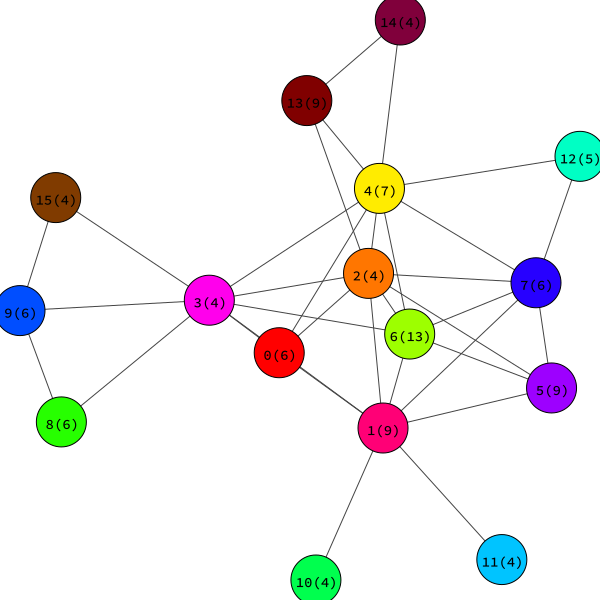

In [9]:
for idx, cluster in enumerate(clusterGraph.vs):
    if cluster.index in clusterIds:
        cluster["size"]=50
    cluster["color"]=partition.subgraph(idx).vs[0]["color"]
    cluster["label"]="{}({})".format(idx,cluster["nb_workers"])
ig.plot(clusterGraph)

In [10]:
for v in F.vs:
    if v["name"] in workerIds:
        v["size"]=25
        v["shape"]="triangle"
    else:
        v["size"]=1
        v["shape"]="circle"

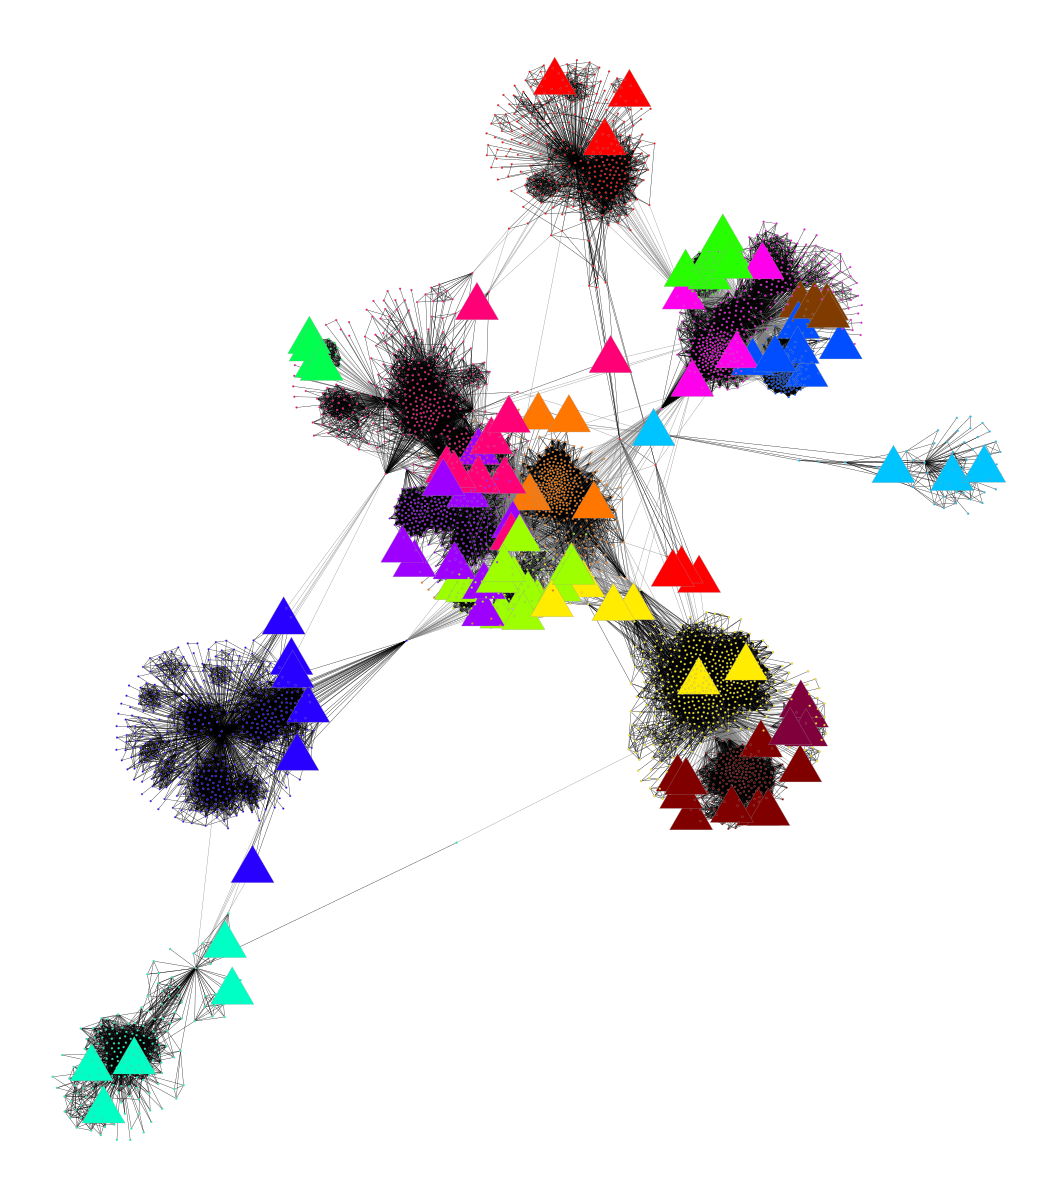

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f171fdc9a30, at 0x7f17592e5370>

In [11]:
G=F.to_graph_tool(vertex_attributes={"color":"vector<float>","size":"int","shape":"string"},edge_attributes={"color":"vector<float>"})
gt.graph_draw(G, vertex_fill_color=G.vertex_properties["color"],vertex_shape=G.vertex_properties["shape"],vertex_size=G.vertex_properties["size"],edge_color=G.edge_properties["color"])

## Evaluate

Same Counter({2: 530, 3: 82, 1: 14})
Other Counter({4: 3120, 3: 2704, 2: 1836, 5: 912, 6: 522, 7: 150, 8: 18, 1: 12})


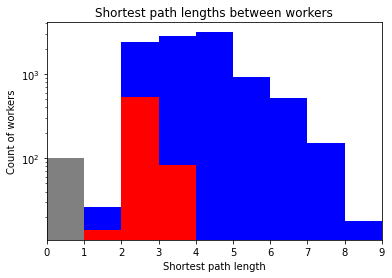

In [24]:
import numpy as np
from matplotlib import pyplot as plt

data=list(graphDistances(F,workerIds))
maxDist=max([max(l,default=0) for l in data],default=0)
colors=["grey","red","blue"]
labels=["self","same community","other community"]
# fixed bin size
bins = np.arange(0, 100, 1) # fixed bin size

plt.xlim([0, maxDist+1])
plt.yscale("log")
plt.hist(data, bins=bins, color=colors, label=labels, stacked=True)
plt.title('Shortest path lengths between workers')
plt.xlabel('Shortest path length')
plt.ylabel('Count of workers')

plt.show()

In [25]:
#the greater the value, the better
print(sum([sum(l) for l in data]))

34482


### Intra cluster distances

Same Counter({3: 18, 2: 12})
Other Counter({3: 263, 4: 179, 2: 59, 5: 30, 6: 24, 7: 9})
Same Counter({2: 42, 3: 30})
Other Counter({3: 313, 2: 255, 4: 183, 5: 41, 6: 27})
Same Counter({2: 12})
Other Counter({2: 145, 3: 143, 4: 64, 5: 20, 6: 12})
Same Counter({2: 12})
Other Counter({4: 118, 3: 114, 2: 107, 5: 21, 6: 10, 7: 9, 1: 5})
Same Counter({2: 30, 3: 12})
Other Counter({2: 233, 3: 191, 4: 172, 5: 39, 6: 15, 1: 1})
Same Counter({2: 72})
Other Counter({3: 300, 2: 271, 4: 176, 5: 45, 6: 27})
Same Counter({2: 156})
Other Counter({3: 431, 2: 339, 4: 258, 5: 66, 6: 36, 1: 1})
Same Counter({2: 20, 3: 10})
Other Counter({4: 284, 5: 133, 3: 115, 6: 25, 2: 4, 7: 3})
Same Counter({2: 26, 1: 4})
Other Counter({4: 369, 2: 87, 5: 36, 3: 33, 6: 18, 7: 18, 1: 3})
Same Counter({2: 30})
Other Counter({4: 340, 2: 89, 3: 63, 5: 35, 7: 18, 6: 17, 1: 2})
Same Counter({2: 8, 1: 4})
Other Counter({4: 184, 3: 168, 5: 12, 6: 12, 2: 8})
Same Counter({2: 12})
Other Counter({5: 183, 6: 75, 3: 60, 4: 42, 7: 9,

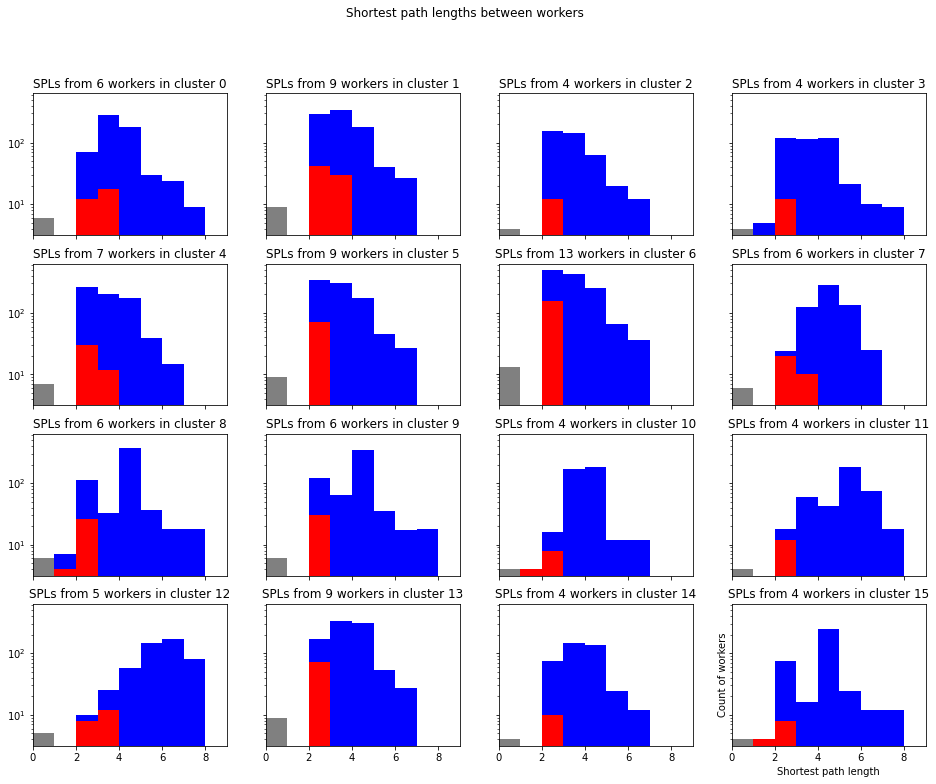

In [26]:
import numpy as np
from matplotlib import pyplot as plt

nbClusters=len(partition.subgraphs())
nbCol=4
fig,ax = plt.subplots(nrows = nbClusters//nbCol, ncols = nbCol,sharex=True, sharey=True,figsize=(nbCol*4,3*nbClusters//nbCol))

for idx, subgraph in enumerate(partition.subgraphs()):
    inClusterWorkers=[w for w in workerIds if w in subgraph.vs["name"]]
    data=list(graphDistances(F,inClusterWorkers,workerIds,subgraph.vs[0]["cluster"]))
    colors=["grey","red","blue"]
    labels=["self","same community","other community"]

    # fixed bin size
    bins = np.arange(0, maxDist+1, 1) # fixed bin size

    ax[idx//nbCol][idx%nbCol].hist(data, bins=bins, color=colors, label=labels, stacked=True)
    ax[idx//nbCol][idx%nbCol].title.set_text('SPLs from {} worker{} in cluster {}'.format(len(inClusterWorkers),"s" if len(inClusterWorkers)>1 else "",idx))
plt.xlim([0, maxDist+1])
plt.yscale("log")
plt.suptitle('Shortest path lengths between workers')
plt.xlabel('Shortest path length')
plt.ylabel('Count of workers')
plt.show()

## Graph Metrics

### Max distance between nodes (graph diameter)

In [27]:
print(F.diameter())

8


### Distances inter-nodes intra-clusters (cluster diameters)

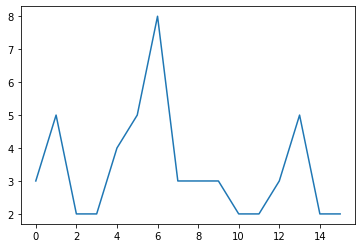

In [28]:
subgraphs=partition.subgraphs()
diameters=list([subgraph.diameter() for subgraph in subgraphs])
plt.plot(diameters)

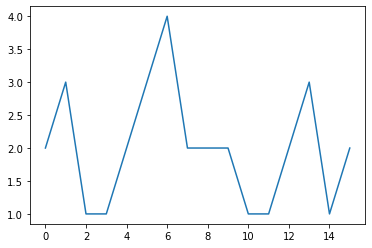

In [29]:
radii=list([subgraph.radius() for subgraph in subgraphs])
plt.plot(radii)

### Nodes per community

In [30]:
from collections import Counter
nbClusters=len(Counter(F.vs["cluster"]))

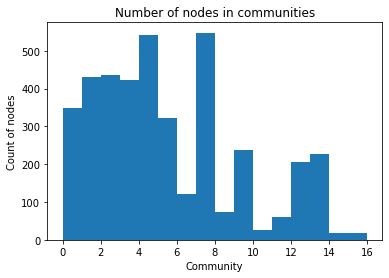

In [31]:
bins = np.arange(0, nbClusters+1, 1)
plt.hist(F.vs["cluster"], bins=bins)
plt.title('Number of nodes in communities')
plt.xlabel('Community')
plt.ylabel('Count of nodes')

plt.show()

### Workers per cluster

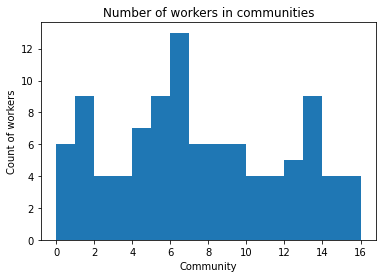

In [32]:
data=[F.vs.find(worker)["cluster"] for worker in workerIds]
bins = np.arange(0, nbClusters+1, 1)
plt.hist(data, bins=bins)
plt.title('Number of workers in communities')
plt.xlabel('Community')
plt.ylabel('Count of workers')

plt.show()

### Cluster diameter based worker count

In [33]:
diameters=[subgraph.diameter() for subgraph in partition.subgraphs()]

workers=[diameter//2+diameter%2 for diameter in diameters]
assignedWorkers=sum(workers)
print(assignedWorkers)

31
